## Analyzing outputs of 100 parameter sets ensemble simulaitons

Analyzing the first batch of ensemble simulations. <br/>
Simulation outputs stored: /home/disk/eos8/ach315/upscale/sims/opt

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import xarray as xr
import datetime
import seaborn as sns

### 1. Loading in parameter information

In [3]:
df_params = pd.read_csv('/home/disk/eos8/ach315/upscale/inits/param_100.csv')
df_params.head()

,staygreen,rmax_lir,rmax_ltar,juv_leaves,leaf_wid,WLRATIO,A_LW,LAF,f,scatt,vcm_25,vpm_25,g0,g1,t_opt,psi_threshold
0,4.192327,0.170936,1.116221,19,0.060117,1.578166,0.578437,1.082704,0.374039,0.799075,41.453395,63.020343,0.050014,4.262101,23.156285,-3.209627
1,5.085099,0.458642,0.532489,13,0.053712,1.593230,0.944650,2.500608,0.084047,0.638286,55.254491,76.360963,0.045041,9.476365,21.452484,-4.528151
2,5.462802,0.409265,1.126607,19,0.055231,1.452949,0.615309,1.305084,0.209307,0.547004,40.314858,68.638982,0.071773,3.290494,25.081642,-1.387541
3,2.468920,0.159873,0.209975,14,0.021548,1.951003,0.603160,1.430029,0.198690,0.216546,53.057031,71.797256,0.102321,3.169339,26.865773,-3.101738
4,2.217561,0.478633,0.463970,16,0.045654,1.027741,0.790700,1.147568,0.793187,0.582211,50.710891,78.179130,0.099021,6.539257,27.086055,-1.328671


### 2. Setting up xarray infrastructure to hold data

200423 - not sure if I'm actually going to store simulation output in xarray

In [4]:
df_siteinfo = pd.read_csv("/home/disk/eos8/ach315/upscale/weadata/site_info.csv", index_col=0, dtype=str)
df_siteinfo.head()

,site,city,state,lat,lon
0,03103,FLAGSTAFF,AZ,35.08,111.4
1,03812,ASHEVILLE,NC,35.26,82.32
2,03813,MACON,GA,32.42,83.39
3,03820,AUGUSTA,GA,33.22,81.58
4,03822,SAVANNAH,GA,32.08,81.12


In [5]:
sites = df_siteinfo.site
lat = df_siteinfo.lat
lon = df_siteinfo.lon
years = np.arange(1961,1991)
cultivars = np.arange(1,101)

In [6]:
ds = xr.Dataset()

### 3. Reading in simulation outputs

Thoughts: <br/>
Maybe I can create several pandas files that have sites as columns and time as rows. <br/>
I'll create 100 of these for all the cultivars. <br/>
I'll then use 'numpy.dstack' to stack all these 2d dataframes into a 3d matrix. <br/>
I'll then use this 3d matrix as the data input for xarray.

In [247]:
def get_filelist(path):
    '''
    For the given path, get the List of all files in the directory tree
    including those in subdirectories
    '''
    # create a list of file and sub directories names in the given directory 
    filelist = os.scandir(path)
    allfiles = list()
    # iterate over all the entries
    for entry in filelist:
        # create full path
        fullpath = os.path.join(path, entry)
        # if entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullpath):
            allfiles = allfiles + get_filelist(fullpath)
        else:
            allfiles.append(fullpath)
    return allfiles

In [274]:
%%time

# fetching all simulation outputs
filelist = get_filelist('/home/disk/eos8/ach315/upscale/sims/opt/')

# manual update of maizsim output column name
cols = ['year', 'cvar', 'site',
        'date', 'jday', 'time', 
        'leaves', 'mature_lvs', 'drop_lvs', 'LA', 'LA_dead', 'LAI', 
        'RH', 'leaf_WP', 'PFD', 'solrad', 'temp_soil', 'temp_air', 'temp_can', 'ET_dmd', 'ET_suply',
        'Pn', 'Pg', 'resp', 'av_gs', 'LAI_sunlit', 'LAI_shaded', 'PFD_sunlit', 'PFD_shaded', 
        'An_sunlit', 'An_shaded', 'Ag_sunlit', 'Ag_shaded', 'gs_sunlit', 'gs_shaded', 'VPD',
        'N', 'N_dmd', 'N_upt', 'N_leaf', 'PCRL', 'dm_total', 'dm_shoot', 'dm_ear', 'dm_totleaf', 'dm_dropleaf', 
        'df_stem', 'df_root', 'roil_rt', 'mx_rootdept', 'available_water', 'soluble_c', 'note']

CPU times: user 4.93 s, sys: 9.95 s, total: 14.9 s
Wall time: 25.6 s


In [275]:
%%time

years = []
cvars = []
sites = []
data_all = []
issues = []

files = filelist[:]

for file in files:
    # extrating basic file info
    year = file.split('/')[-3]
    site = file.split('/')[-1].split('_')[1]
    cvar = file.split('/')[-1].split('_')[-1].split('.')[0]
    
    # reading in file and setting up structure
    with open(file, 'r') as f:
        f.seek(0, os.SEEK_END) # moving the pointer to the very end of the file
                               # * f.seek(offset, whence)
                               # * The position is computed from adding offset to a reference point,
                               # * the reference point is selected by the whence argument.
                               # * os.SEEK_SET (=0)
                               # * os.SEEK_CUR (=1)
                               # * os.SEEK_END (=2)
        f.seek(f.tell() - 3000, os.SEEK_SET) # finding the current position (which should be at the very end of the file)
                                             # and counting back a few positions 
                                             # and reading forward from there
                                             # * f.tell() returns an integer giving the file object’s 
                                             # * current position in the file represented as number of bytes 
                                             # * from the beginning of the file when in binary mode 
                                             # * and an opaque number when in text mode.

        for line in f:
            f_content = f.readlines()

        if len(f_content[-1]) == 523: # character length of a normal output
            sim_output = list(f_content[-1].split(','))
            data = [i.strip() for i in sim_output]
            data.insert(0, year)
            data.insert(1, cvar)
            data.insert(2, site)
            data_all.append(data)

        else: 
            issues.append(file)

# converting output to dataframe
df_sims = pd.DataFrame(data_all, columns=cols)
df_sims.dm_total = df_sims.dm_total.astype(float)
df_sims.dm_ear = df_sims.dm_ear.astype(float)
df_issues = pd.Series(issues)

# storing outputs
# df_issues.to_csv('/home/disk/eos8/ach315/upscale/test/sims_issues.txt')
# df_sims.to_csv('/home/disk/eos8/ach315/upscale/test/sims_6190_all.txt')

CPU times: user 48.3 s, sys: 23 s, total: 1min 11s
Wall time: 28min 7s


In [281]:
df_sims.head()

,year,cvar,site,date,jday,time,leaves,mature_lvs,drop_lvs,LA,...,dm_ear,dm_totleaf,dm_dropleaf,df_stem,df_root,roil_rt,mx_rootdept,available_water,soluble_c,note
0,1961,0,03813,08/08/1961,22501,5,19.91,19,12,1781.77,...,0.0,4.87,4.48,2.14,44.106,44.214,0.0,0.000,0.04,"""Matured"""
1,1961,0,03820,08/27/1961,22520,14,20.13,20,20,0.00,...,0.0,25.56,25.56,-72.80,71.395,71.554,0.0,0.000,0.00,"""Matured"""
2,1961,0,03822,07/23/1961,22485,20,18.13,17,10,2800.57,...,0.0,5.14,4.36,2.25,42.663,42.726,0.0,0.000,0.05,"""Matured"""
3,1961,0,03856,07/31/1961,22493,14,17.13,16,9,2955.69,...,0.0,4.24,3.29,1.85,41.752,41.806,0.0,0.000,0.06,"""Emerged"""
4,1961,0,03928,07/30/1961,22492,2,17.13,16,9,2935.66,...,0.0,3.83,2.89,1.80,44.587,44.672,0.0,0.000,0.20,"""Emerged"""


In [282]:
df_sims.tail()

,year,cvar,site,date,jday,time,leaves,mature_lvs,drop_lvs,LA,...,dm_ear,dm_totleaf,dm_dropleaf,df_stem,df_root,roil_rt,mx_rootdept,available_water,soluble_c,note
211957,1990,99,94240,04/28/1990,32991,16,0.50,0,0,0.00,...,0.0,0.22,0.00,0.03,0.110,0.115,0.0,0.000,0.00,"""Matured"""
211958,1990,99,94822,04/25/1990,32988,9,0.50,0,0,0.00,...,0.0,0.22,0.00,0.03,0.110,0.115,0.0,0.000,0.00,"""Matured"""
211959,1990,99,94823,04/24/1990,32987,17,0.50,0,0,0.00,...,0.0,0.22,0.00,0.03,0.110,0.115,0.0,0.000,0.00,"""Matured"""
211960,1990,99,94830,04/25/1990,32988,14,0.50,0,0,0.00,...,0.0,0.22,0.00,0.03,0.110,0.115,0.0,0.000,0.00,"""Matured"""
211961,1990,99,94910,04/24/1990,32987,9,0.50,0,0,0.00,...,0.0,0.21,0.00,0.03,0.110,0.115,0.0,0.000,0.00,"""Matured"""



### 4. Reading in pre-stored final line of simulation and filtering out sites

In [212]:
# reading in raw simulation outputs
df_simulations = pd.read_csv('/home/disk/eos8/ach315/upscale/test/sims_6190.txt', index_col=0) 
                # there is now an updated compiled sim file ('sims_6190_all.txt')
# reading in filtered sites
df_filtsites = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/sites_filtered.csv', index_col=0)
# merging two dataframes - filtering out unwanted sites - should only have 87 sites left
df_sims = pd.merge(df_simulations, df_filtsites, how='inner', on=['site', 'site'])
df_sims.head()

,year,cultivar,site,biomass,ear,devstage,years,city,state,lat,lon,area,perct_irri
0,1961,0,3820,47.734,0.00,"""Matured""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
1,1961,1,3820,109.384,29.88,"""grainFill""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
2,1961,2,3820,148.455,9.52,"""grainFill""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
3,1961,3,3820,0.352,0.00,"""Matured""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
4,1961,4,3820,31.105,2.53,"""Matured""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754


In [84]:
# Seperating out simulations that eneded in Maturation vs. those that didn't
df_matured = df_sims[df_sims.devstage == '"Matured"']
df_premature = df_sims[df_sims.devstage != '"Matured"']

In [210]:
df_sims.groupby('site').count().head()

,year,cultivar,biomass,ear,devstage,years,city,state,lat,lon,area,perct_irri
site,,,,,,,,,,,,
3820,900,900,900,900,900,900,900,900,900,900,900,900
3856,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300
3927,600,600,600,600,600,600,600,600,600,600,600,600
3928,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100
3945,700,700,700,700,700,700,700,700,700,700,700,700


In [88]:
df_matured.head()

,year,cultivar,site,biomass,ear,devstage,years,city,state,lat,lon,area,perct_irri
0,1961,0,3820,47.734,0.00,"""Matured""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
3,1961,3,3820,0.352,0.00,"""Matured""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
4,1961,4,3820,31.105,2.53,"""Matured""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
6,1961,6,3820,95.216,8.01,"""Matured""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
7,1961,7,3820,0.352,0.00,"""Matured""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754


In [89]:
df_premature.head()

,year,cultivar,site,biomass,ear,devstage,years,city,state,lat,lon,area,perct_irri
1,1961,1,3820,109.384,29.88,"""grainFill""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
2,1961,2,3820,148.455,9.52,"""grainFill""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
5,1961,5,3820,33.629,1.41,"""grainFill""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
10,1961,10,3820,13.625,1.98,"""grainFill""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
11,1961,11,3820,12.142,1.33,"""grainFill""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754


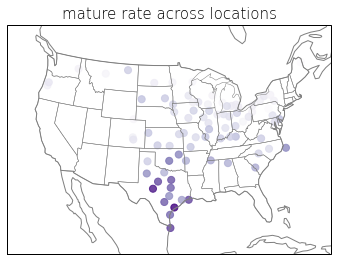

In [41]:
# maturate rate across sites
mature_rate = list((df_matured.groupby('site').count().year)/(df_sims.groupby('site').count().year))

# plotting map
from palettable.colorbrewer.sequential import Purples_9

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1, 
                     projection=ccrs.AlbersEqualArea(
                         central_latitude=39.5, central_longitude=-98.35))
ax.set_extent([-123, -72, 19, 53])
ax.scatter(df_matured.groupby('site').mean().lon*-1, df_matured.groupby('site').mean().lat, 
           transform=ccrs.PlateCarree(), s=50, c=mature_rate, cmap=Purples_9.mpl_colormap, alpha=0.8)

ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title('mature rate across locations', fontweight='light', fontsize=15)
fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/sites_weastation.png', format='png', dpi=800)

#*** 200511: it's interesting/weird that southrn locations have a higher maturation rate
#            this might have something to do with temperature.. 

In [19]:
df_matured.head()

,year,cultivar,site,biomass,ear,devstage,years,city,state,lat,lon,area,perct_irri
0,1961,0,3820,47.734,0.00,"""Matured""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
3,1961,3,3820,0.352,0.00,"""Matured""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
4,1961,4,3820,31.105,2.53,"""Matured""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
6,1961,6,3820,95.216,8.01,"""Matured""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
7,1961,7,3820,0.352,0.00,"""Matured""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754


In [79]:
df_premature.head()

,year,cultivar,site,biomass,ear,devstage,years,city,state,lat,lon,area,perct_irri
1,1961,1,3820,109.384,29.88,"""grainFill""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
2,1961,2,3820,148.455,9.52,"""grainFill""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
5,1961,5,3820,33.629,1.41,"""grainFill""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
10,1961,10,3820,13.625,1.98,"""grainFill""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
11,1961,11,3820,12.142,1.33,"""grainFill""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754


In [10]:
df_premature.tail()

,year,cultivar,site,biomass,ear,devstage,years,city,state,lat,lon,area,perct_irri
95329,1990,30,12912,90.601,0.00,"""Emerged""",16,VICTORIA,TX,28.51,96.55,76320.0,4.827274
95338,1990,39,12912,13.848,0.00,"""Emerged""",16,VICTORIA,TX,28.51,96.55,76320.0,4.827274
95346,1990,47,12912,47.353,0.00,"""Emerged""",16,VICTORIA,TX,28.51,96.55,76320.0,4.827274
95347,1990,48,12912,142.078,21.68,"""grainFill""",16,VICTORIA,TX,28.51,96.55,76320.0,4.827274
95356,1990,57,12912,558.886,0.02,"""grainFill""",16,VICTORIA,TX,28.51,96.55,76320.0,4.827274


### Investigating 4 simulation cases for debugging purposes
1. run_03820_1961_var_0.txt
2. run_03820_1961_var_3.txt
3. run_03820_1961_var_1.txt
4. run_12912_1990_var_30.txt

#### Quick look at parameter values first
- issues: var0, 3, & 30
- good: var1

In [3]:
df_params = pd.read_csv('/home/disk/eos8/ach315/upscale/inits/param_100.csv')
df_params = df_params.iloc[[0,1,3,30], :]
df_params.index = ['var0','var1','var3','var30']
df_params

,staygreen,rmax_lir,rmax_ltar,juv_leaves,leaf_wid,WLRATIO,A_LW,LAF,f,scatt,vcm_25,vpm_25,g0,g1,t_opt,psi_threshold
var0,4.192327,0.170936,1.116221,19,0.060117,1.578166,0.578437,1.082704,0.374039,0.799075,41.453395,63.020343,0.050014,4.262101,23.156285,-3.209627
var1,5.085099,0.458642,0.532489,13,0.053712,1.593230,0.944650,2.500608,0.084047,0.638286,55.254491,76.360963,0.045041,9.476365,21.452484,-4.528151
var3,2.468920,0.159873,0.209975,14,0.021548,1.951003,0.603160,1.430029,0.198690,0.216546,53.057031,71.797256,0.102321,3.169339,26.865773,-3.101738
var30,4.308304,0.113473,0.900777,18,0.024615,1.171935,0.607410,2.061111,0.180131,0.052547,54.826520,73.040447,0.112302,1.608984,27.633592,-2.744836


#### Case1: run_03820_1961_var_0.txt
- 'Matured' between 'Emergence' & 'Tassel initiation'
- last terminal output pheno stage - 'Silking'
- got lumped into df_matured since the last log was indeed 'Matured' but obviously something went wrong during the simulation
- model ran but did not reach grain-filling stage, hence no final yield
- total biomass started crashing towards the end?
- grain filling never happened

#### Potential mechanisms/notes
- matured prior to other reproductive pheno stages
- all leaves have senesced before grain filling which led to issues with scale & Fraction that caused C allocation to be all messed up after tassel initiation
- scale is calcualted by (phyllochron from tassel initiation)/(leaves initiated - leaves appeared)
    - after all leaves have initiated, leaves initiated becomes (int) leaves initiated while leaves appeared remains as decimal points
    - this leads to LvsInitiated < LvsAppeared, which makes scale a negative number
    - this further affects Fraction as well
    - and everything gets messes up after tassel initation (which is when scale is no longer 0 and Fractio no longer 0.5) 
- low leaf tip initiation rate and/or in high juvenile leaf number could lead to early maturation (prior to other reproductive stages)
    - while I don't think this actually affects the model, it leads to bad model output that miss information on other reproductive pheno stages pheno stages (maksed by mature)
- if all leaves have appeared by tassel initiation (at this point, all leaves would have initiated, but not necessarily have appeared, in reality, likely not)
    - then it'd be quite likely that you end up with LvsAppeared being slightly highter than LvsInitiated due to the few decimal points, which leads to bad scale & Fractions
    - this then leads to issues with scale & Fraction, which makes C allocation after tassel initiation all messed up
    - I think this is probably also why plant ends up with no ear biomass

In [69]:
cols = ['jday', 'time', 
        'leaves', 'mature_lvs', 'drop_lvs', 'LA', 'LA_dead', 'LAI', 
        'RH', 'leaf_WP', 'PFD', 'solrad', 'temp_soil', 'temp_air', 'temp_can', 'ET_dmd', 'ET_suply',
        'Pn', 'Pg', 'resp', 'av_gs', 'LAI_sunlit', 'LAI_shaded', 'PFD_sunlit', 'PFD_shaded', 
        'An_sunlit', 'An_shaded', 'Ag_sunlit', 'Ag_shaded', 'gs_sunlit', 'gs_shaded', 'VPD',
        'N', 'N_dmd', 'N_upt', 'N_leaf', 'PCRL', 'dm_total', 'dm_shoot', 'dm_ear', 'dm_totleaf', 'dm_dropleaf', 
        'df_stem', 'df_root', 'roil_rt', 'mx_rootdept', 'available_water', 'soluble_c', 'note']

In [85]:
df1 = pd.read_csv('/home/disk/eos8/ach315/upscale/sims/opt/1961/var_0/out1_03820_1961_var_0.txt')
df1.columns = cols
df1.note = [i.strip() for i in df1.note]

In [86]:
set(df1.note)

{'"Emerged"', '"Germinated"', '"Matured"', '"none"'}

In [37]:
df1[df1.note == '"Matured"'].head() # here can see that model 'matured' prior to other reproductive pheno stages

,jday,time,leaves,mature_lvs,drop_lvs,LA,LA_dead,LAI,RH,leaf_WP,...,dm_ear,dm_totleaf,dm_dropleaf,df_stem,df_root,roil_rt,mx_rootdept,available_water,soluble_c,note
07/26/1961,22488,15,17.13,16,10,2861.05,1630.15,2.86,40.85,-1.5,...,0.0,4.57,3.88,1.99,41.078,41.135,0.0,0.0,0.06,"""Matured"""
07/26/1961,22488,16,17.13,16,10,2862.16,1630.15,2.86,39.33,-1.5,...,0.0,4.57,3.88,1.99,41.125,41.180,0.0,0.0,0.06,"""Matured"""
07/26/1961,22488,17,17.13,16,10,2863.23,1630.15,2.86,40.69,-1.5,...,0.0,4.57,3.88,1.99,41.174,41.229,0.0,0.0,0.06,"""Matured"""
07/26/1961,22488,18,17.13,17,10,2864.27,1630.15,2.86,49.71,-1.5,...,0.0,4.57,3.88,1.99,41.222,41.279,0.0,0.0,0.06,"""Matured"""
07/26/1961,22488,19,17.18,17,10,2864.27,1630.15,2.86,64.65,-1.5,...,0.0,4.57,3.88,1.99,41.263,41.324,0.0,0.0,0.06,"""Matured"""


In [59]:
df1[df1.jday == 22507].head() # tassel initiation on jday 22507
                              # this also seems like when C partitioning broke down for total biomass
                              # see graph below 

,jday,time,leaves,mature_lvs,drop_lvs,LA,LA_dead,LAI,RH,leaf_WP,...,dm_ear,dm_totleaf,dm_dropleaf,df_stem,df_root,roil_rt,mx_rootdept,available_water,soluble_c,note
08/14/1961,22507,0,20.13,20,13,1512.34,3125.62,1.51,90.55,-1.5,...,0.0,4.68,4.45,1.99,43.898,44.012,0.0,0.0,0.0,"""Matured"""
08/14/1961,22507,1,20.13,20,13,1511.03,3126.93,1.51,89.95,-1.5,...,0.0,4.68,4.45,1.99,43.898,44.012,0.0,0.0,0.0,"""Matured"""
08/14/1961,22507,2,20.13,20,13,1509.71,3128.24,1.51,93.36,-1.5,...,0.0,4.68,4.45,1.99,43.898,44.012,0.0,0.0,0.0,"""Matured"""
08/14/1961,22507,3,20.13,20,13,1508.35,3129.61,1.51,93.36,-1.5,...,0.0,4.68,4.45,1.99,43.898,44.012,0.0,0.0,0.0,"""Matured"""
08/14/1961,22507,4,20.13,20,13,1506.97,3130.98,1.51,93.34,-1.5,...,0.0,4.68,4.45,1.99,43.898,44.012,0.0,0.0,0.0,"""Matured"""


In [56]:
df1[df1.jday == 22508].head() # tassel fully emerged on jday 22508
                              # this also seems like when C partitioning broke down for total biomass
                              # see graph below 

,jday,time,leaves,mature_lvs,drop_lvs,LA,LA_dead,LAI,RH,leaf_WP,...,dm_ear,dm_totleaf,dm_dropleaf,df_stem,df_root,roil_rt,mx_rootdept,available_water,soluble_c,note
08/15/1961,22508,0,20.13,20,13,1453.29,3184.66,1.45,78.21,-1.5,...,0.0,4.70,4.45,1.96,43.964,44.078,0.0,0.0,0.0,"""Matured"""
08/15/1961,22508,1,20.13,20,13,1450.54,3187.41,1.45,81.13,-1.5,...,0.0,4.70,4.45,1.96,43.987,44.101,0.0,0.0,0.0,"""Matured"""
08/15/1961,22508,2,20.13,20,13,1447.73,3190.22,1.45,78.06,-1.5,...,0.0,4.70,4.45,1.95,44.011,44.126,0.0,0.0,0.0,"""Matured"""
08/15/1961,22508,3,20.13,20,13,1444.87,3193.09,1.44,75.58,-1.5,...,0.0,4.71,4.45,1.94,44.038,44.153,0.0,0.0,0.0,"""Matured"""
08/15/1961,22508,4,20.13,20,13,1442.02,3195.94,1.44,77.99,-1.5,...,0.0,4.71,4.45,1.94,44.068,44.183,0.0,0.0,0.0,"""Matured"""


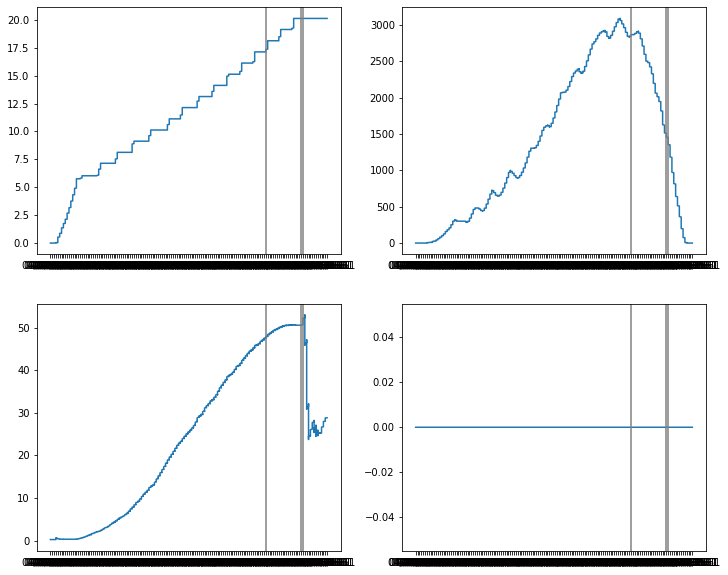

In [66]:
df = df1
outputs = ['leaves', 'LA', 'dm_total', 'dm_ear']

fig, axs = plt.subplots(2, 2, figsize=(12,10))
for ax, i in zip(axs.flatten(), outputs):
    ax.plot(df[i])
    ax.axvline('07/26/1961', color='grey') # mature
    ax.axvline('08/14/1961', color='grey') # tassel initiation
    ax.axvline('08/15/1961', color='grey') # tassel fully emerged

#### Case2: run_03820_1961_var_3.txt
- df_matured
- reached 'Physiological maturity' (instead of 'Matured') but skipped thorugh many stages
- simualtion ended very early (4/14) - model barely ran, no leaf growth, very little biomass, no yield
- also, why did the very last pheno-stage just jump to "Matured"?

#### Potential mechanisms/notes
- plant emerged prior to any leaves appeared
- this triggered "physiological maturity" since green leaf area <= 0.05 leaf area (which both were actually just 0) prior to maturity, and triggered maturity and death
- simulation ended really early
- likely caused by a low leaf tip appearance rate

In [5]:
df2 = pd.read_csv('/home/disk/eos8/ach315/upscale/sims/opt/1961/var_3/out1_03820_1961_var_3.txt')
df2.columns = cols
df2.note = [i.strip() for i in df2.note]
df2.tail()

,jday,time,leaves,mature_lvs,drop_lvs,LA,LA_dead,LAI,RH,leaf_WP,...,dm_ear,dm_totleaf,dm_dropleaf,df_stem,df_root,roil_rt,mx_rootdept,available_water,soluble_c,note
04/14/1961,22385,13,0.85,0,0,0.0,0.0,0.0,36.87,-0.05,...,0.0,0.22,0.0,0.03,0.11,0.115,0.0,0.0,0.0,"""Germinated"""
04/14/1961,22385,14,0.86,0,0,0.0,0.0,0.0,32.99,-0.05,...,0.0,0.22,0.0,0.03,0.11,0.115,0.0,0.0,0.0,"""Germinated"""
04/14/1961,22385,15,0.87,0,0,0.0,0.0,0.0,33.51,-0.05,...,0.0,0.22,0.0,0.03,0.11,0.115,0.0,0.0,0.0,"""Germinated"""
04/14/1961,22385,16,0.88,0,0,0.0,0.0,0.0,34.85,-0.05,...,0.0,0.22,0.0,0.03,0.11,0.115,0.0,0.0,0.0,"""Germinated"""
04/14/1961,22385,17,0.89,0,0,0.0,0.0,0.0,32.41,-0.05,...,0.0,0.22,0.0,0.03,0.11,0.115,0.0,0.0,0.0,"""Matured"""


In [6]:
set(df2.note)

{'"Germinated"', '"Matured"', '"none"'}

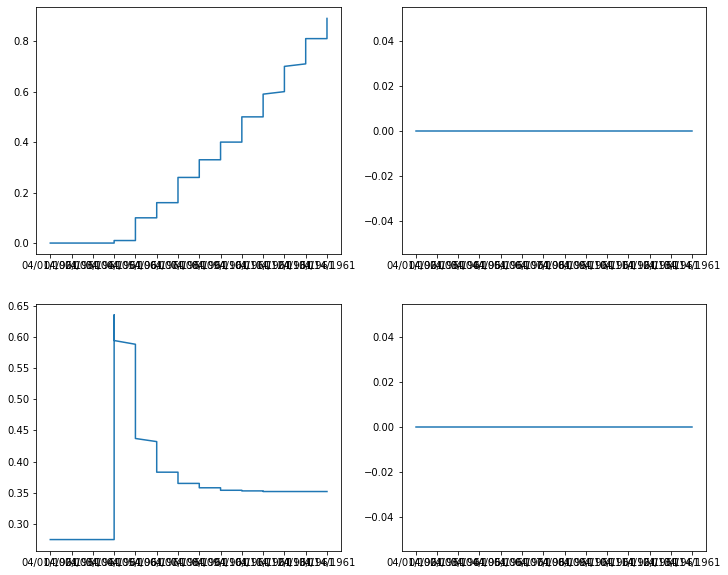

In [7]:
df = df2
outputs = ['leaves', 'LA', 'dm_total', 'dm_ear']

fig, axs = plt.subplots(2, 2, figsize=(12,10))
for ax, i in zip(axs.flatten(), outputs):
    ax.plot(df[i])

#### Case3: run_03820_1961_var_1.txt
This is the only good simulation out of these 4 cases

In [83]:
df3 = pd.read_csv('/home/disk/eos8/ach315/upscale/sims/opt/1961/var_1/out1_03820_1961_var_1.txt')
df3.columns = cols
df3.note = [i.strip() for i in df3.note]
df3.tail()

,jday,time,leaves,mature_lvs,drop_lvs,LA,LA_dead,LAI,RH,leaf_WP,...,dm_ear,dm_totleaf,dm_dropleaf,df_stem,df_root,roil_rt,mx_rootdept,available_water,soluble_c,note
08/02/1961,22495,7,13.0,13,12,0.15,2619.08,0.0,96.32,-1.5,...,30.06,5.46,4.84,7.74,66.669,66.817,0.0,0.0,0.08,"""Matured"""
08/02/1961,22495,8,13.0,13,12,0.06,2619.17,0.0,90.03,-1.5,...,30.06,5.46,4.84,7.74,66.669,66.817,0.0,0.0,0.09,"""Matured"""
08/02/1961,22495,9,13.0,13,12,0.01,2619.22,0.0,84.16,-1.5,...,30.06,5.46,4.84,7.75,66.669,66.817,0.0,0.0,0.09,"""Matured"""
08/02/1961,22495,10,13.0,13,12,0.00,2619.23,0.0,68.88,-1.5,...,30.06,5.46,4.84,7.75,66.669,66.817,0.0,0.0,0.09,"""Matured"""
08/02/1961,22495,11,13.0,13,13,0.00,2619.23,0.0,67.05,-1.5,...,30.06,5.46,5.46,7.75,66.669,66.817,0.0,0.0,0.10,"""Matured"""


In [84]:
set(df3.note)

{'"Emerged"',
 '"Germinated"',
 '"Matured"',
 '"Silked"',
 '"Tasseled"',
 '"Tasselinit"',
 '"grainFill"',
 '"none"'}

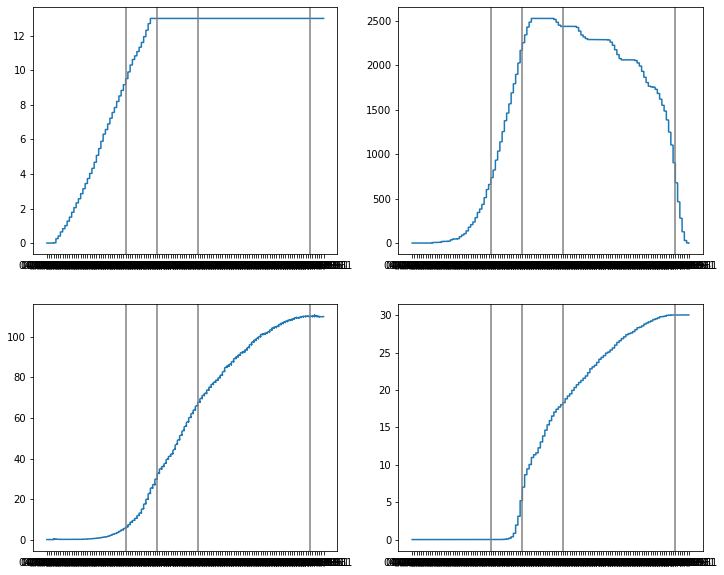

In [68]:
df = df3
outputs = ['leaves', 'LA', 'dm_total', 'dm_ear']

fig, axs = plt.subplots(2, 2, figsize=(12,10))
for ax, i in zip(axs.flatten(), outputs):
    ax.plot(df[i])
    ax.axvline('05/06/1961', color='grey') # Tasselinit
    ax.axvline('05/20/1961', color='grey') # Tasseled
    ax.axvline('06/07/1961', color='grey') # grainFill
    ax.axvline('07/27/1961', color='grey') # Matured

#### Case4: run_12912_1990_var_30.txt: 
- 'Matued' between 'Emergence' & 'Tassel initiation'
- ended with 'Fortran runtime error: End of file
- issue seems to be with hourwea.for, line 304

#### Potential mechanisms/notes
- Matured prior to other reproductive pheno stages
- Total green leaf area reached 0 (all leaves have senesced) prior to tassel initiation
- N also got depleted - this doesn't really mess up the whole simulation but there can no longer be any leaf area gain. This point on, plant only senesces. I want to avoid any issues with N stress, so will need to further look into if there are ways to avoid this.
- The main issue is still that all leaves senesced prior to tassel initiation, which caused N_effect to become NaN

In [74]:
df4 = pd.read_csv('/home/disk/eos8/ach315/upscale/sims/opt/1990/var_30/out1_12912_1990_var_30.txt')
df4.columns = cols
df4.tail()

,jday,time,leaves,mature_lvs,drop_lvs,LA,LA_dead,LAI,RH,leaf_WP,...,dm_ear,dm_totleaf,dm_dropleaf,df_stem,df_root,roil_rt,mx_rootdept,available_water,soluble_c,note
10/30/1990,33176,19,20.11,20,14,0.0,2832.01,0.0,83.66,-1.5,...,0.0,79.76,18.72,-242.22,182.09,182.285,0.0,0.0,0.0,"""Matured"""
10/30/1990,33176,20,20.11,20,14,0.0,2832.01,0.0,89.70,-1.5,...,0.0,79.76,18.72,-242.22,182.09,182.285,0.0,0.0,0.0,"""Matured"""
10/30/1990,33176,21,20.11,20,14,0.0,2832.01,0.0,93.19,-1.5,...,0.0,79.76,18.72,-242.22,182.09,182.285,0.0,0.0,0.0,"""Matured"""
10/30/1990,33176,22,20.11,20,14,0.0,2832.01,0.0,93.14,-1.5,...,0.0,79.76,18.72,-242.22,182.09,182.285,0.0,0.0,0.0,"""Matured"""
10/30/1990,33176,23,20.11,20,14,0.0,2832.01,0.0,96.80,-1.5,...,0.0,79.76,18.72,-242.22,182.09,182.285,0.0,0.0,0.0,"""Matured"""


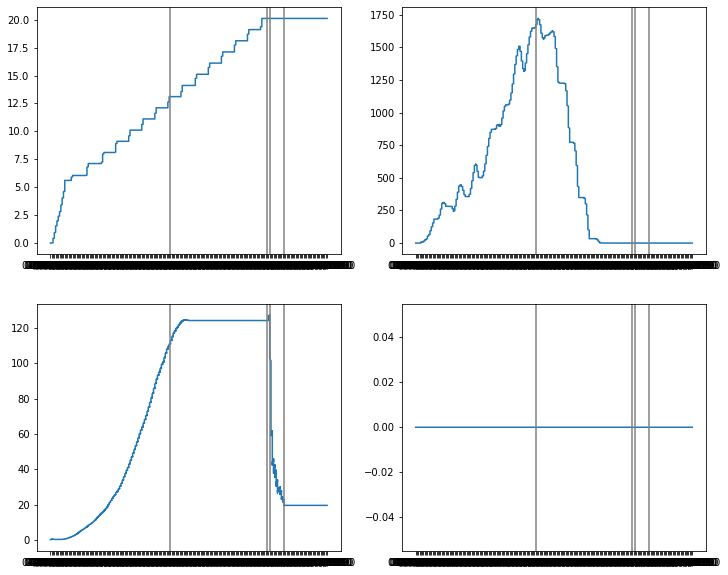

In [81]:
df = df4
outputs = ['leaves', 'LA', 'dm_total', 'dm_ear']

fig, axs = plt.subplots(2, 2, figsize=(12,10))
for ax, i in zip(axs.flatten(), outputs):
    ax.plot(df[i])
    ax.axvline('07/02/1990', color='grey') # matured: matured prior to other stages
    ax.axvline('09/14/1990', color='grey') # tassel initiation
    ax.axvline('09/16/1990', color='grey') # tasseled
    ax.axvline('09/27/1990', color='grey') # grain filling

### General look at all outputs

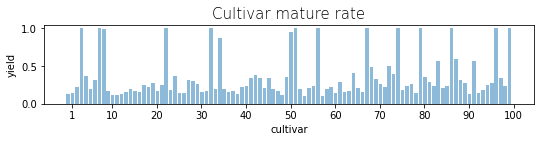

In [42]:
# mature rate across cultivars
mature_rate = list((df_matured.groupby('cultivar').count().year)/(df_sims.groupby('cultivar').count().year))

# plotting
x = np.arange(len(mature_rate))
width = 0.8
ticks = [0.5,9.5,19.5,29.5,39.5,49.5,59.5,69.5,79.5,89.5,99.5]
labels = [1,10,20,30,40,50,60,70,80,90,100]

fig, ax = plt.subplots(figsize=(8,2))
ax.bar(x-width/2, mature_rate, width, alpha=0.5)
ax.set_ylabel('yield')
ax.set_xlabel('cultivar')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_title('Cultivar mature rate', fontweight='light', fontsize=15)
fig.subplots_adjust(left=0.1, bottom=0.25, right=0.95, top=0.8)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/var100_ear.png', format='png', dpi=800)

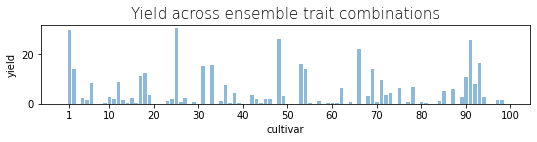

In [119]:
# yield across cultivars
means = df_matured.groupby(['cultivar']).mean().ear
x = np.arange(len(means))
width = 0.8
ticks = [0.5,9.5,19.5,29.5,39.5,49.5,59.5,69.5,79.5,89.5,99.5]
labels = [1,10,20,30,40,50,60,70,80,90,100]

fig, ax = plt.subplots(figsize=(8,2))
ax.bar(x-width/2, means, width, alpha=0.5)
ax.set_ylabel('yield')
ax.set_xlabel('cultivar')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_title('Yield across ensemble trait combinations', fontweight='light', fontsize=15)
fig.subplots_adjust(left=0.1, bottom=0.25, right=0.95, top=0.8)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/var100_ear.png', format='png', dpi=800)

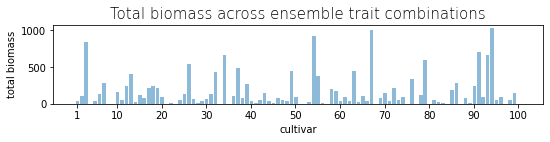

In [103]:
# total biomass across cultivars
means = df_matured.groupby(['cultivar']).mean().biomass
x = np.arange(len(means))
width = 0.8
ticks = [-0.5,8.5,18.5,28.5,38.5,48.5,58.5,68.5,78.5,88.5,98.5]
# not sure why ticks are slightly off 
# had to make this weird adjustment to make things match
labels = [1,10,20,30,40,50,60,70,80,90,100]


fig, ax = plt.subplots(figsize=(8,2))
ax.bar(x-width/2, means, width, alpha=0.5)
ax.set_ylabel('total biomass')
ax.set_xlabel('cultivar')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_title('Total biomass across ensemble trait combinations', fontweight='light', fontsize=15)
fig.subplots_adjust(left=0.1, bottom=0.25, right=0.95, top=0.8)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/var100_tbiomass.png', format='png', dpi=800)

### Looking into what site-year-cultivars failed to finish running

It could either be:
- issues with sites
- certain years
- certain cultivar combinations

In [44]:
test = pd.concat([df_params, pd.Series(df_matured.groupby('cultivar').mean().ear)], axis=1)
test.rename(columns={0:'ear'}, inplace=True)

In [45]:
test.columns

Index(['staygreen', 'rmax_lir', 'rmax_ltar', 'juv_leaves', 'leaf_wid',
       'WLRATIO', 'A_LW', 'LAF', 'f', 'scatt', 'vcm_25', 'vpm_25', 'g0', 'g1',
       't_opt', 'psi_threshold', 'ear'],
      dtype='object')

In [46]:
test.head()

,staygreen,rmax_lir,rmax_ltar,juv_leaves,leaf_wid,WLRATIO,A_LW,LAF,f,scatt,vcm_25,vpm_25,g0,g1,t_opt,psi_threshold,ear
0,4.192327,0.170936,1.116221,19,0.060117,1.578166,0.578437,1.082704,0.374039,0.799075,41.453395,63.020343,0.050014,4.262101,23.156285,-3.209627,0.015210
1,5.085099,0.458642,0.532489,13,0.053712,1.593230,0.944650,2.500608,0.084047,0.638286,55.254491,76.360963,0.045041,9.476365,21.452484,-4.528151,29.743309
2,5.462802,0.409265,1.126607,19,0.055231,1.452949,0.615309,1.305084,0.209307,0.547004,40.314858,68.638982,0.071773,3.290494,25.081642,-1.387541,14.029393
3,2.468920,0.159873,0.209975,14,0.021548,1.951003,0.603160,1.430029,0.198690,0.216546,53.057031,71.797256,0.102321,3.169339,26.865773,-3.101738,0.000000
4,2.217561,0.478633,0.463970,16,0.045654,1.027741,0.790700,1.147568,0.793187,0.582211,50.710891,78.179130,0.099021,6.539257,27.086055,-1.328671,2.430930


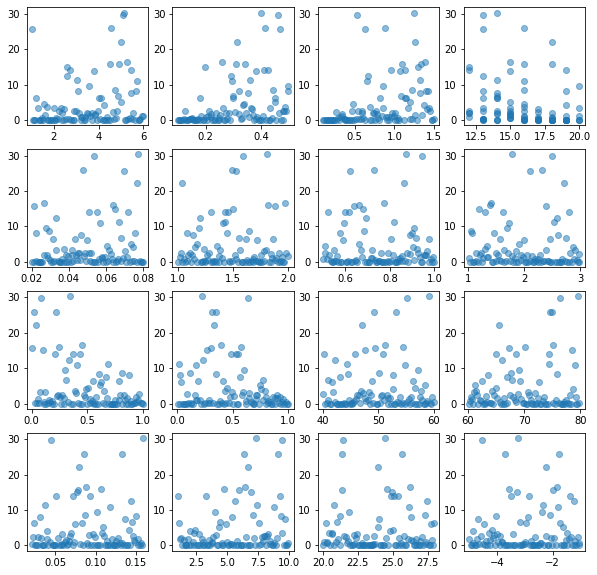

In [48]:
fig = plt.figure(figsize=(10,10))


for i in np.arange(1,17): 
    ax = fig.add_subplot(4,4,i)
    ax.scatter(test.iloc[:,i-1], test.iloc[:,-1], alpha=0.5)

In [26]:
from partial_corr import partial_corr

In [49]:
output = partial_corr(test)

In [51]:
pd.DataFrame(output, columns=test.columns, index=test.columns)

,staygreen,rmax_lir,rmax_ltar,juv_leaves,leaf_wid,WLRATIO,A_LW,LAF,f,scatt,vcm_25,vpm_25,g0,g1,t_opt,psi_threshold,ear
staygreen,1.000000,-0.142592,0.135371,0.136653,0.128767,0.139712,0.005287,-0.052044,0.105451,-0.006845,0.055691,0.017539,0.029123,-0.055506,0.049777,0.250682,0.187976
rmax_lir,-0.142592,1.000000,-0.096931,0.207101,-0.025890,-0.039146,0.033869,-0.070227,0.322872,0.403767,-0.115091,0.045305,0.044873,0.027204,0.133724,0.133510,0.502277
rmax_ltar,0.135371,-0.096931,1.000000,0.264405,0.104771,-0.027002,0.071122,-0.055544,0.187744,0.032016,-0.017457,-0.156302,0.015016,-0.008919,0.064350,-0.136776,0.359979
juv_leaves,0.136653,0.207101,0.264405,1.000000,0.003422,0.106738,0.017822,0.026544,-0.319905,0.045397,0.141900,0.305496,0.085429,0.018787,0.108382,0.039826,-0.428823
leaf_wid,0.128767,-0.025890,0.104771,0.003422,1.000000,-0.085732,0.018914,0.112596,0.044376,-0.045571,-0.001883,0.048193,-0.132575,0.119076,0.131961,-0.234994,0.063112
WLRATIO,0.139712,-0.039146,-0.027002,0.106738,-0.085732,1.000000,-0.088366,0.072004,-0.012143,0.005090,0.138416,0.183051,-0.231903,0.295203,0.115396,-0.092283,-0.014633
A_LW,0.005287,0.033869,0.071122,0.017822,0.018914,-0.088366,1.000000,0.157260,0.060238,0.067050,0.127751,0.180816,0.041331,0.165216,0.070455,-0.015898,-0.039984
LAF,-0.052044,-0.070227,-0.055544,0.026544,0.112596,0.072004,0.157260,1.000000,0.132780,0.208508,-0.012943,0.175462,-0.094411,0.081109,-0.031136,0.017060,0.071715
f,0.105451,0.322872,0.187744,-0.319905,0.044376,-0.012143,0.060238,0.132780,1.000000,-0.228139,0.066983,0.148200,0.106895,-0.071877,0.046863,-0.006496,-0.520318
scatt,-0.006845,0.403767,0.032016,0.045397,-0.045571,0.005090,0.067050,0.208508,-0.228139,1.000000,0.384571,-0.162196,-0.088919,0.066136,-0.143750,-0.040858,-0.325358


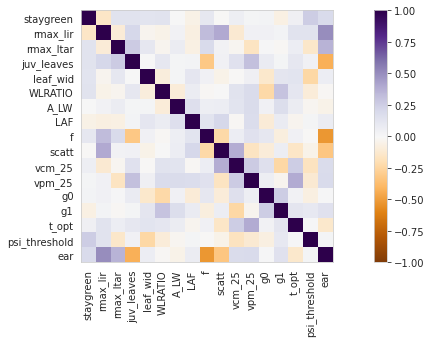

In [109]:
params = test.columns

with sns.axes_style('whitegrid'): # adding this line just makes the figure look a bit nicer
    
    fig, ax = plt.subplots(figsize=(8,5))
    im = ax.imshow(output, cmap='PuOr', vmin=-1, vmax=1)
    ax.set_xticks(np.arange(0,17))
    ax.set_xticklabels(params, rotation=90)
    ax.set_yticks(np.arange(0,17))
    ax.set_yticklabels(params, rotation=0)

    ax.grid(False)
    plt.colorbar(im)
    fig.subplots_adjust(left=-0.5, bottom=0.25, right=0.95, top=0.95)

    
    # 200429 - can further add * to indicate statistical significance
    #          when you have that info
    # 200429 - now that I'm thinking more, this figure is probably overkill
    #          since I don't really need all the correlatoins between all parameters
    #          maybe can modifiy this later to show correlation with different model output
    #          such as ear, total biomass, season length, etc. 

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/pcc.png', dpi=800)